In [67]:
import pickle
import pandas as pd
from tqdm import tqdm

In [68]:
with open('email_campaigns.pkl','rb') as f:
    data = pickle.load(f)

In [69]:
data[16]

{'MarketingAnalyticsSeries': [{'subject': '🚀 Boost Your Marketing ROI with Advanced Analytics!',
   'body': "Hello [Recipient's Name],\n\nAre you harnessing the full power of your marketing data? With [Your Company]'s advanced analytics services, you can amplify your marketing ROI and get granular insights into customer behavior.\n\nLet's dig into your data together! 👩\u200d💻 Click here [meeting link] to book a strategy session. Can I reserve a spot for you this week?\n\nBest,\n[Your Name]",
   'opened': True,
   'meeting link clicked': False,
   'responded': False},
  {'subject': "Re: Personalized Insights for [Recipient's Company] Marketing Strategy 📊",
   'body': "Hi [Recipient's Name],\n\nI noticed you checked out our email about supercharging your marketing efforts with analytics but haven't booked a session yet. We've helped companies like yours increase campaign conversion rates by up to 25%!\n\nLet's explore what [Your Company]'s analytics can do for you. Here’s the [meeting li

In [70]:
cols = ['thread_id','subject','body','email_num','previous_opened','opened','meeting_link_clicked','responded']
df_data = []
k = 0
for row in tqdm(data):
    
    
    for thread in row.values():
        prev_opened = False
        for i,msg in enumerate(thread):
            if type(msg) == dict:
                thread_num = k
                sub = msg['subject']
                body = msg['body']
                email_num = i+1 # Number of Email sent for that thread
                opened = msg['opened']
                try:
                    mlc = msg['meeting link clicked']
                except:
                    mlc = msg['meeting_link_clicked']
                resp = msg['responded']
                df_data.append([k,sub,body,email_num,prev_opened,opened,mlc,resp])
                prev_opened = opened
        k += 1

df = pd.DataFrame(data = df_data, columns= cols)
df.head()

100%|██████████| 52/52 [00:00<00:00, 32135.52it/s]


,thread_id,subject,body,email_num,previous_opened,opened,meeting_link_clicked,responded
0,0,🚀 Propel Your Marketing ROI with Advanced Anal...,"Hey [Recipient's Name],\n\nReady to see your m...",1,False,False,False,False
1,0,Data is Your Superpower 📊 Unlock Insights with Us,"Hi [Recipient's Name],\n\nI'm reaching out aga...",2,False,True,False,False
2,0,Turn Marketing Data Into Decisions 🧐 Let's Exp...,"Greetings [Recipient's Name],\n\nWe haven't co...",3,True,False,False,False
3,0,Marketing Success is a Click Away - Let's Chat...,"Hello [Recipient's Name],\n\nIt's clear that y...",4,False,True,True,False
4,1,🚀 Boost Your Brand's Visibility with Proven Ma...,"Hi [Recipient's Name],\n\nIn the digital age, ...",1,False,False,False,False


In [71]:
df[(df['opened'] == True) & (df['previous_opened'] == False)].drop_duplicates(subset='thread_id').head()

,thread_id,subject,body,email_num,previous_opened,opened,meeting_link_clicked,responded
1,0,Data is Your Superpower 📊 Unlock Insights with Us,"Hi [Recipient's Name],\n\nI'm reaching out aga...",2,False,True,False,False
5,1,Turn Data into Decisions 📊 - Your Next Competi...,"Hey [Recipient's Name],\n\nI saw that my previ...",2,False,True,False,False
9,2,Your Marketing Strategy Deserves the Best Anal...,"Hello [Recipient's Name],\n\nImprove your mark...",2,False,True,False,False
11,3,💡 Elevate Your Marketing with Actionable Insig...,"Hi [Recipient's Name],\n\nAre you leveraging y...",1,False,True,False,False
14,4,🚀 Propel Your Marketing with Data-Driven Insights,"Hello [Recipient's Name],\n\nAre you harnessin...",1,False,True,False,False


#### Finding out on an average how many emails it takes for a user to open and view it

In [72]:
import matplotlib.pyplot as plt
grp = df[(df['opened'] == True) & (df['previous_opened'] == False)].drop_duplicates(
    subset='thread_id',
).groupby('email_num')['opened'].count()
grp = grp/53 * 100
grp

email_num
1    69.811321
2    30.188679
Name: opened, dtype: float64

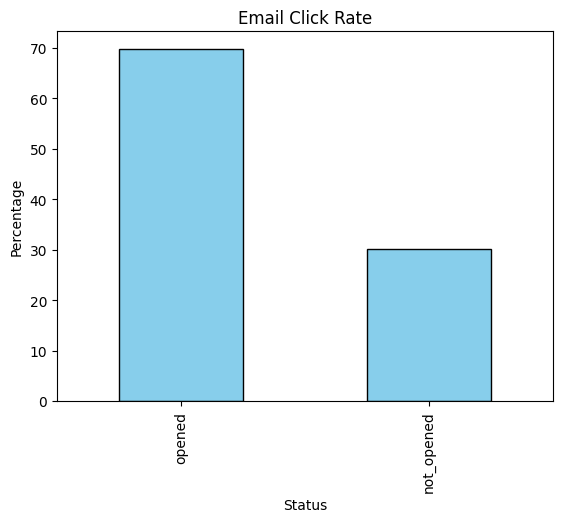

In [73]:
grp.index = ['opened','not_opened']
grp.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Email Click Rate')
plt.xlabel('Status')
plt.ylabel('Percentage')
plt.show()

So ~70% of the people view the first email send to them, as the subject line is the reason one would open the email, let's see why for the remaing 30% it took more than one email.

We are going to train a Classification model using a Transformers model then use word attribution scores to find patterns in subject lines, like what words lead to higher rejection rate.

As Subject line plays a very important role wether a message get's opened or not. We are going to train a classifier on the Email subject line, and target variable being whether it get's opened or not.

We are going to only consider the First Email sent to the customer, to find a pattern which shows what makes subject line successful and engages the customer.

In [74]:
import nltk
from nltk.corpus import stopwords
import demoji

def remove_emojis_and_stopwords(subject_line):
    """
    Function to clean the subject text.
    """
    # Remove emojis
    subject_line_no_emojis = demoji.replace(subject_line, repl="")

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = subject_line_no_emojis.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]

    # Join the filtered words back into a sentence
    filtered_subject_line = ' '.join(filtered_words)

    return filtered_subject_line


In [75]:
df['subject'] = df['subject'].apply(func=remove_emojis_and_stopwords)

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import  accuracy_score,classification_report
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset
from torch.nn import CrossEntropyLoss
import torch

df_sub = df[df['email_num'] == 1][['subject','opened']]
df_sub['opened'] = df_sub['opened'].astype(int)
df_sub.head()

,subject,opened
0,Propel Marketing ROI Advanced Analytics!,0
4,Boost Brand's Visibility Proven Marketing Anal...,0
8,Boost ROI Precision Marketing Analytics,0
11,Elevate Marketing Actionable Insights!,1
14,Propel Marketing Data-Driven Insights,1


In [83]:
# We are going to use DistilBERT as it is a lightweight model perfect for developing a PoC.
# Load DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)



In [78]:
# Split the dataset into training and testing sets, 
train_df, test_df = train_test_split(df_sub, test_size=0.2, random_state=17,stratify=df_sub['opened'])

In [79]:
test_df

,subject,opened
106,Propel Marketing Data Insights,1
42,Elevate Marketing ROI Us,1
133,Boost Conversions Advanced Marketing Analytics,1
46,Elevate Marketing Data-Driven Insights!,1
35,Elevate Marketing ROI - Let's Talk Strategy!,1
136,Empower Marketing Precise Analytics,1
4,Boost Brand's Visibility Proven Marketing Anal...,0
146,Elevate Human Capital Management,0
26,Ready Enhance Marketing Analytics Game?,1
125,Unlock Marketing Potential Advanced Analytics,1


In [80]:
# Developing a Custom Torch Dataset
class EmailDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])
        inputs = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_len, return_tensors='pt')

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

train_dataset = EmailDataset(train_df['subject'].values, train_df['opened'].values, tokenizer)
test_dataset = EmailDataset(test_df['subject'].values, test_df['opened'].values, tokenizer)

In [81]:
train_df, test_df = train_test_split(df_sub, test_size=0.2, random_state=17,stratify=df_sub['opened'])
train_dataset = EmailDataset(train_df['subject'].values, train_df['opened'].values, tokenizer)
test_dataset = EmailDataset(test_df['subject'].values, test_df['opened'].values, tokenizer)

In [82]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [15]:
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score
# Training settings
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=20,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=11,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_strategy='epoch',
    save_total_limit=1,
    load_best_model_at_end=True,
    save_strategy='epoch',
    evaluation_strategy='epoch',
)



In [16]:

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=lambda p: {"accuracy": accuracy_score(p.predictions.argmax(axis=1), p.label_ids)}
)

# Train the model
trainer.train()


  0%|          | 0/120 [00:00<?, ?it/s]

{'loss': 0.6838, 'learning_rate': 2.7272727272727273e-05, 'epoch': 1.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.6493955254554749, 'eval_accuracy': 0.7272727272727273, 'eval_runtime': 0.3492, 'eval_samples_per_second': 31.499, 'eval_steps_per_second': 5.727, 'epoch': 1.0}
{'loss': 0.6093, 'learning_rate': 4.954128440366973e-05, 'epoch': 2.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.5844001173973083, 'eval_accuracy': 0.7272727272727273, 'eval_runtime': 0.2049, 'eval_samples_per_second': 53.696, 'eval_steps_per_second': 9.763, 'epoch': 2.0}
{'loss': 0.5756, 'learning_rate': 4.678899082568808e-05, 'epoch': 3.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.5817338228225708, 'eval_accuracy': 0.7272727272727273, 'eval_runtime': 0.1983, 'eval_samples_per_second': 55.458, 'eval_steps_per_second': 10.083, 'epoch': 3.0}
{'loss': 0.5818, 'learning_rate': 4.403669724770643e-05, 'epoch': 4.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.5578433275222778, 'eval_accuracy': 0.7272727272727273, 'eval_runtime': 0.1543, 'eval_samples_per_second': 71.279, 'eval_steps_per_second': 12.96, 'epoch': 4.0}
{'loss': 0.5974, 'learning_rate': 4.1284403669724776e-05, 'epoch': 5.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.5551095604896545, 'eval_accuracy': 0.7272727272727273, 'eval_runtime': 0.1846, 'eval_samples_per_second': 59.573, 'eval_steps_per_second': 10.831, 'epoch': 5.0}
{'loss': 0.4569, 'learning_rate': 3.8532110091743125e-05, 'epoch': 6.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.5666660666465759, 'eval_accuracy': 0.7272727272727273, 'eval_runtime': 0.1654, 'eval_samples_per_second': 66.488, 'eval_steps_per_second': 12.089, 'epoch': 6.0}
{'loss': 0.362, 'learning_rate': 3.5779816513761474e-05, 'epoch': 7.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.5659582018852234, 'eval_accuracy': 0.5454545454545454, 'eval_runtime': 0.1807, 'eval_samples_per_second': 60.887, 'eval_steps_per_second': 11.07, 'epoch': 7.0}
{'loss': 0.1995, 'learning_rate': 3.302752293577982e-05, 'epoch': 8.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.528540849685669, 'eval_accuracy': 0.8181818181818182, 'eval_runtime': 0.1607, 'eval_samples_per_second': 68.459, 'eval_steps_per_second': 12.447, 'epoch': 8.0}
{'loss': 0.1672, 'learning_rate': 3.027522935779817e-05, 'epoch': 9.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.5925667881965637, 'eval_accuracy': 0.8181818181818182, 'eval_runtime': 0.203, 'eval_samples_per_second': 54.199, 'eval_steps_per_second': 9.854, 'epoch': 9.0}
{'loss': 0.0688, 'learning_rate': 2.7522935779816515e-05, 'epoch': 10.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.6254596710205078, 'eval_accuracy': 0.8181818181818182, 'eval_runtime': 0.1574, 'eval_samples_per_second': 69.896, 'eval_steps_per_second': 12.708, 'epoch': 10.0}
{'loss': 0.0338, 'learning_rate': 2.4770642201834864e-05, 'epoch': 11.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.7360125184059143, 'eval_accuracy': 0.8181818181818182, 'eval_runtime': 0.1757, 'eval_samples_per_second': 62.618, 'eval_steps_per_second': 11.385, 'epoch': 11.0}
{'loss': 0.0211, 'learning_rate': 2.2018348623853213e-05, 'epoch': 12.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.8093520998954773, 'eval_accuracy': 0.8181818181818182, 'eval_runtime': 0.1702, 'eval_samples_per_second': 64.645, 'eval_steps_per_second': 11.754, 'epoch': 12.0}
{'loss': 0.0119, 'learning_rate': 1.9266055045871563e-05, 'epoch': 13.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.8593757152557373, 'eval_accuracy': 0.8181818181818182, 'eval_runtime': 0.1877, 'eval_samples_per_second': 58.619, 'eval_steps_per_second': 10.658, 'epoch': 13.0}
{'loss': 0.0088, 'learning_rate': 1.651376146788991e-05, 'epoch': 14.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.8799095153808594, 'eval_accuracy': 0.8181818181818182, 'eval_runtime': 0.1925, 'eval_samples_per_second': 57.139, 'eval_steps_per_second': 10.389, 'epoch': 14.0}
{'loss': 0.0074, 'learning_rate': 1.3761467889908258e-05, 'epoch': 15.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.9270334243774414, 'eval_accuracy': 0.8181818181818182, 'eval_runtime': 0.1611, 'eval_samples_per_second': 68.259, 'eval_steps_per_second': 12.411, 'epoch': 15.0}
{'loss': 0.0063, 'learning_rate': 1.1009174311926607e-05, 'epoch': 16.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.9550788998603821, 'eval_accuracy': 0.8181818181818182, 'eval_runtime': 0.1779, 'eval_samples_per_second': 61.844, 'eval_steps_per_second': 11.244, 'epoch': 16.0}
{'loss': 0.0056, 'learning_rate': 8.256880733944954e-06, 'epoch': 17.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.9734348058700562, 'eval_accuracy': 0.8181818181818182, 'eval_runtime': 0.1565, 'eval_samples_per_second': 70.299, 'eval_steps_per_second': 12.782, 'epoch': 17.0}
{'loss': 0.005, 'learning_rate': 5.504587155963303e-06, 'epoch': 18.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.9836869835853577, 'eval_accuracy': 0.8181818181818182, 'eval_runtime': 0.1576, 'eval_samples_per_second': 69.781, 'eval_steps_per_second': 12.687, 'epoch': 18.0}
{'loss': 0.0049, 'learning_rate': 2.7522935779816517e-06, 'epoch': 19.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.9883907437324524, 'eval_accuracy': 0.8181818181818182, 'eval_runtime': 0.1605, 'eval_samples_per_second': 68.522, 'eval_steps_per_second': 12.459, 'epoch': 19.0}
{'loss': 0.0064, 'learning_rate': 0.0, 'epoch': 20.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.9889837503433228, 'eval_accuracy': 0.8181818181818182, 'eval_runtime': 0.1654, 'eval_samples_per_second': 66.521, 'eval_steps_per_second': 12.095, 'epoch': 20.0}
{'train_runtime': 89.1114, 'train_samples_per_second': 9.426, 'train_steps_per_second': 1.347, 'train_loss': 0.22067020190879702, 'epoch': 20.0}


TrainOutput(global_step=120, training_loss=0.22067020190879702, metrics={'train_runtime': 89.1114, 'train_samples_per_second': 9.426, 'train_steps_per_second': 1.347, 'train_loss': 0.22067020190879702, 'epoch': 20.0})

In [17]:

# Evaluate the model
results = trainer.evaluate()
results

  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.528540849685669,
 'eval_accuracy': 0.8181818181818182,
 'eval_runtime': 0.4637,
 'eval_samples_per_second': 23.723,
 'eval_steps_per_second': 4.313,
 'epoch': 20.0}

In [18]:

# Evaluation loop

test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)
model.eval()
all_preds = []
all_labels = []
device = model.device
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy and other metrics
classification_rep = classification_report(all_labels, all_preds)

print("Classification Report:")
print(classification_rep)


Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.67      0.67         3
           1       0.88      0.88      0.88         8

    accuracy                           0.82        11
   macro avg       0.77      0.77      0.77        11
weighted avg       0.82      0.82      0.82        11



In [120]:
from transformers_interpret import SequenceClassificationExplainer

In [121]:
model.to('cpu');
multiclass_explainer = SequenceClassificationExplainer(model=model, tokenizer=tokenizer)

In [143]:
sample_text = "Elevate Human Capital Management"

In [159]:
word_attributions = multiclass_explainer(text=sample_text,class_name='LABEL_1')

In [160]:
word_attributions

[('[CLS]', 0.0),
 ('el', -0.6536834703806546),
 ('##eva', -0.36886253095942423),
 ('##te', -0.22798471429082967),
 ('human', -0.024416826358496437),
 ('capital', 0.010999772216787915),
 ('management', 0.6196322679273557),
 ('[SEP]', 0.0)]

In [142]:
multiclass_explainer.visualize();

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,LABEL_1 (0.75),LABEL_1,0.33,[CLS] prop ##el marketing roi advanced analytics ! [SEP]


In [172]:
def combine_sub_tokens(inp_lst):
    
    output_list = []
    current_word = ''
    current_score = 0.0
    word_count = 0

    for word, score in inp_lst:
        if word == '[CLS]':
            continue
        if '##' in word:
            current_word += word.replace('##', '')
            current_score += score
            word_count += 1
        else:
            if current_word:
                output_list.append((current_word, current_score/word_count))

            current_word = word
            current_score = score
            word_count = 1
    
    return output_list


In [175]:
word_dict = {}
for text in tqdm(df_sub['subject']):
    word_attributions = multiclass_explainer(text=text,class_name='LABEL_1')
    word_attributions = combine_sub_tokens(word_attributions)
    for word,score in word_attributions:
        if word not in word_dict:
            word_dict[word] = []
        word_dict[word].append(score)

100%|██████████| 53/53 [00:42<00:00,  1.25it/s]


In [176]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [190]:
top_word_dict = {k:sum(v)/len(v) for k,v in word_dict.items() if len(v) > 4 and k not in stop_words}
top_word_dict = dict(sorted(top_word_dict.items(),key=lambda x: x[1]))
top_word_dict

{'analytics': -0.5219179874409404,
 'growth': -0.34898159678477514,
 'proven': -0.3324776707881423,
 'elevate': -0.2842481889238682,
 "'": -0.11296614625127081,
 'boost': -0.1122713902583692,
 'roi': -0.09154994921881045,
 'potential': -0.0601425469457069,
 'hr': -0.024753173901003803,
 'marketing': 0.056742979042126426,
 'insights': 0.09795815145652348,
 'data': 0.15148675668886363,
 'driven': 0.1531395165343926,
 '-': 0.19829072343029303,
 'advanced': 0.3736534071035435,
 'unlock': 0.3766549843198935,
 'brand': 0.38885716896181055,
 'tailored': 0.4114183190479298,
 'empower': 0.45479473030482437,
 'strategies': 0.4793301943297455,
 '!': 0.6016611298398377}

From the above results we can see that the top 3 words that leads to people not opening emails are
| Keyword | Attribution Score | Opened Rate | Example                                           |
|---------|------------------|--------|-------------------------------------------------------|
| Proven  | -0.33            | 40%    | Boost Brand's Growth Proven Marketing Analytics       |
| Growth  | -0.34            | 50%    | Unlock Growth Tailored Marketing Analytics            |
| Elevate | -0.28            | 53%   | Elevate Marketing Actionable Insights!                 |
| Analytics | -0.52            | 63%   | Elevate Marketing Actionable Insights!                 |


Let's Analyse `Analytics` keyword, as it's attribution score is pretty low but click-through rate is higher as compared to the other found keywords

In [234]:
df_sub[(df_sub['subject'].str.contains('Analytics')) & (df_sub['opened'] == 0)]

,subject,opened
0,Propel Marketing ROI Advanced Analytics!,0
4,Boost Brand's Visibility Proven Marketing Anal...,0
8,Boost ROI Precision Marketing Analytics,0
17,Elevate Brand Tailored Marketing Analytics,0
20,Elevate Marketing Game Proven Analytics!,0
91,Enhance Marketing Cutting-Edge Analytics,0
101,Boost Brand's Growth Proven Marketing Analytics,0
122,Unlock Growth Precision Marketing Analytics,0
131,Supercharge Marketing Insights Data-Driven Ana...,0
138,Elevate Marketing Insights Next-Gen Analytics!,0


We can see for all the cases where subject line contains Analytics is being used, is related to marketing

In [235]:
df_sub[(df_sub['subject'].str.contains('Marketing'))]['opened'].value_counts()

opened
1    25
0    10
Name: count, dtype: int64

In [238]:
df_sub[(df_sub['subject'].str.contains('Marketing')) & (~(df_sub['subject'].str.contains('Analytics')))]['opened'].value_counts()

opened
1    8
Name: count, dtype: int64

We can see above that as soon as we remove Analytics keyword, the click through rate for the Marketing emails, increase from 71% (25/35) to 100%.

So to increase click through rates for Marketing Emails, we should replace Marketing Analytics keyword, with phrases like:
1. Marketing Actionable Insights
2. Marketing Data Insights

Let's see this in action as well

In [249]:
df_sub.loc[[14,0,46,138]]

,subject,opened
14,Propel Marketing Data-Driven Insights,1
0,Propel Marketing ROI Advanced Analytics!,0
46,Elevate Marketing Data-Driven Insights!,1
138,Elevate Marketing Insights Next-Gen Analytics!,0


So we can see 

In [213]:
mask = df_sub['subject'].str.contains('Analytics') & ~df_sub['subject'].str.contains(r'Proven|Growth|Elevate')
df_sub[mask]['opened'].value_counts()

opened
1    12
0     4
Name: count, dtype: int64

In [194]:
17/27 * 100

62.96296296296296

In [191]:
7/13 * 100

53.84615384615385

In [132]:
df_sub[df_sub['opened'] == 0]

,subject,opened
0,Propel Marketing ROI Advanced Analytics!,0
4,Boost Brand's Visibility Proven Marketing Anal...,0
8,Boost ROI Precision Marketing Analytics,0
17,Elevate Brand Tailored Marketing Analytics,0
20,Elevate Marketing Game Proven Analytics!,0
63,Unlock Insights & Rocket Revenue,0
70,Elevate HR Game Expertise,0
76,Enhance Team's Potential Top-Tier HR Consulting,0
91,Enhance Marketing Cutting-Edge Analytics,0
98,Boost Efficiency,0


df_sub[]

In [189]:
df_sub[df_sub['subject'].str.contains('Proven')]

,subject,opened
4,Boost Brand's Visibility Proven Marketing Anal...,0
20,Elevate Marketing Game Proven Analytics!,0
51,Unlock Marketing Potential Proven Analytics St...,1
67,Elevate Brand's Reach Proven Marketing Analytics!,1
101,Boost Brand's Growth Proven Marketing Analytics,0


In [117]:
df[(df['subject'].str.contains('Unlock')) & (df['email_num'] == 1)].loc[[53,122],:]

,thread_id,subject,body,email_num,previous_opened,opened,meeting_link_clicked,responded
53,18,Unlock Growth Tailored Marketing Analytics,"Hi [Recipient's Name],\n\nDo your marketing ef...",1,False,True,False,False
122,43,Unlock Growth Precision Marketing Analytics,"Hi [Recipient’s Name],\n\nDo you feel your mar...",1,False,False,False,False


In [118]:
df_sub[df_sub['subject'].str.contains('Strategies')]

,subject,opened
4,Boost Brand's Visibility Proven Marketing Anal...,0
40,Transform Marketing Strategies Advanced Analytics,1
51,Unlock Marketing Potential Proven Analytics St...,1
55,Elevate Legal Strategies - Let's Partner Up!,1
104,Increase ROI Data-Driven Marketing Strategies,1


In [108]:
df_sub[df_sub['subject'].str.contains('Elevate')]

,subject,opened
11,Elevate Marketing Actionable Insights!,1
17,Elevate Brand Tailored Marketing Analytics,0
20,Elevate Marketing Game Proven Analytics!,0
23,Elevate Brand's Reach Tailored Marketing Analy...,1
35,Elevate Marketing ROI - Let's Talk Strategy!,1
42,Elevate Marketing ROI Us,1
46,Elevate Marketing Data-Driven Insights!,1
55,Elevate Legal Strategies - Let's Partner Up!,1
67,Elevate Brand's Reach Proven Marketing Analytics!,1
70,Elevate HR Game Expertise,0


# Engagement Rate
Trying to find out what leads to people not reponding or setting up meeting after opening up the mail.

In [19]:
df_resp = df[df['opened'] == True][['subject','body','meeting_link_clicked','responded']]
df_resp

,subject,body,meeting_link_clicked,responded
1,Data Superpower Unlock Insights Us,"Hi [Recipient's Name],\n\nI'm reaching out aga...",False,False
3,Marketing Success Click Away - Let's Chat Anal...,"Hello [Recipient's Name],\n\nIt's clear that y...",True,False
5,Turn Data Decisions - Next Competitive Edge,"Hey [Recipient's Name],\n\nI saw that my previ...",False,False
7,"We’re Confident Data, Here’s","Greetings [Recipient's Name],\n\nYour success ...",True,False
9,Marketing Strategy Deserves Best Analytics,"Hello [Recipient's Name],\n\nImprove your mark...",False,False
...,...,...,...,...
147,Re: Unlock Potential Tailored HR Solutions,"Hi [Recipient's Name],\n\nNoticed that you're ...",False,False
149,Streamline HR Boost Performance,"Hello [Recipient's Name],\n\nEfficiency is kin...",True,False
150,Boost Brand Visibility,"Hello [Recipient's Name],\n\nWant to skyrocket...",False,False
151,Outpace Competitors Insightful Analytics,"Hi [Recipient's Name],\n\nI noticed you're nav...",False,False


In [20]:
import re
def clean_body(text):
    # Remove line breaks
    text = text.replace('\n', ' ').replace('\r', '')

    # Remove salutations
    salutations = ['hi', 'hello', 'greetings', 'dear', 'hey']
    for salutation in salutations:
        pattern = re.compile(fr'{salutation}(.*?)[,\n]', re.IGNORECASE)
        text = re.sub(pattern, '', text)

    # Remove extra spaces
    text = ' '.join(text.split())
    text = demoji.replace(text, repl="")

    return text

In [21]:
df_resp['body'] = df_resp['body'].apply(clean_body) 
df_resp.head()

,subject,body,meeting_link_clicked,responded
1,Data Superpower Unlock Insights Us,I'm reac our marketing analytics can translate...,False,False
3,Marketing Success Click Away - Let's Chat Anal...,It's clear that you're serious about your busi...,True,False
5,Turn Data Decisions - Next Competitive Edge,I saw that my previous email hasn’t been opene...,False,False
7,"We’re Confident Data, Here’s","Your success is our business. Just last month,...",True,False
9,Marketing Strategy Deserves Best Analytics,Improve your marketing effectiveness through d...,False,False


In [22]:
df_resp.head()[['body','meeting_link_clicked']].values

array([["I'm reac our marketing analytics can translate your data into actionable strategies that can redefine your marketing's success. Can we help you harness t [Your Name]",
        False],
       ["It's clear that you're serious about your business success, so let's not let untapped data insights stand in the way. Imagine the competitive edge you could gain with our expert analysis and recommendations. When can we show you the full picture? Click here for a consultation: [meeting link]. We’re here to turn your data into your most valuable asset. Warm regards, [Your Name]",
        True],
       ["I saw that my previous email hasn’t been opened. I get it, you're swamped. Still, I couldn't help but reach out again because I truly believe that our marketing analytics insights can make a substantial difference for [Recipient's Company Name]. Here’s the deal in a nutshell: - Customized data reports  - Campaign optimization  - Increased conversion rates  Does t [Your Name]",
        Fals

In [23]:
def count_tokens(text, tokenizer=tokenizer):
    tokens = tokenizer.tokenize(tokenizer.decode(tokenizer.encode(text)))
    return len(tokens)
df_resp['num_tokens'] = df_resp['body'].apply(count_tokens)
df_resp.head() 

,subject,body,meeting_link_clicked,responded,num_tokens
1,Data Superpower Unlock Insights Us,I'm reac our marketing analytics can translate...,False,False,39
3,Marketing Success Click Away - Let's Chat Anal...,It's clear that you're serious about your busi...,True,False,87
5,Turn Data Decisions - Next Competitive Edge,I saw that my previous email hasn’t been opene...,False,False,85
7,"We’re Confident Data, Here’s","Your success is our business. Just last month,...",True,False,122
9,Marketing Strategy Deserves Best Analytics,Improve your marketing effectiveness through d...,False,False,58


In [24]:
df_resp['meeting_link_clicked'] = df_resp['meeting_link_clicked'].astype(int)
df_resp['responded'] = df_resp['responded'].astype(int)

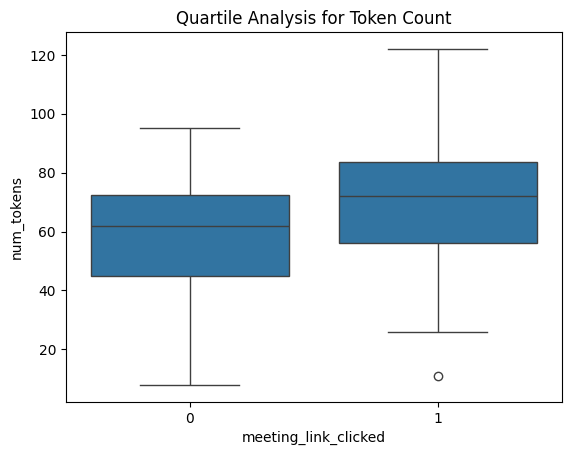

In [25]:
# Analyzing if length of email body has any correlation to response rate.
import seaborn as sns
grouped_df = df_resp.groupby('meeting_link_clicked')['num_tokens'].describe(percentiles=[.25, .5, .75])

# Plot quartile analysis
sns.boxplot(x='meeting_link_clicked', y='num_tokens', data=df_resp)
plt.title('Quartile Analysis for Token Count')
plt.show()

<Axes: >

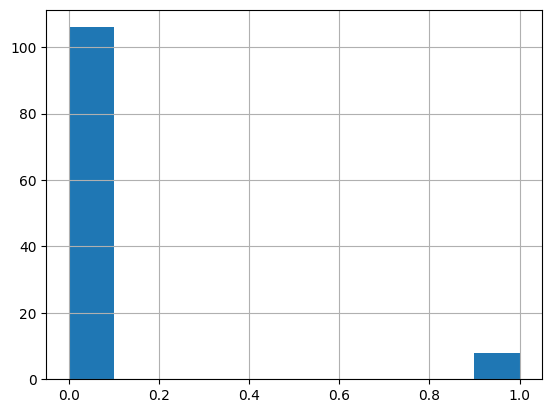

In [26]:
df_resp['responded'].astype(int).hist()

<Axes: >

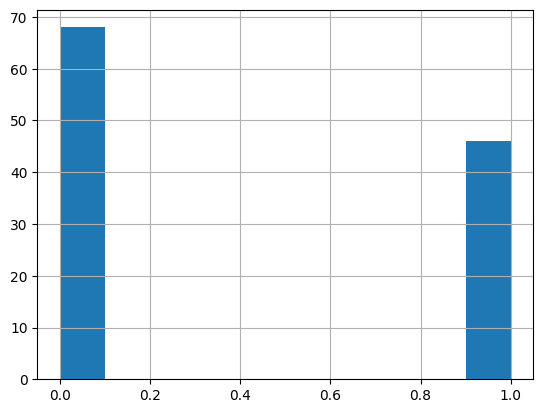

In [268]:
df_resp['meeting_link_clicked'].astype(int).hist()

As we can see the reponded data is avery skewed we are going to `meeting_link_clicked` as a target variable to gauge the engagement

There are multiple things we can do here:

2. Find tone/persuation techniques of email body and correlate with response rate

In [27]:
from dotenv import load_dotenv
load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")

With recent advancements in LLM , they have now come to be used as a great tool for annotating datasets. I am going to use gpt-4 api here, as it is easy to setup and no compute is required, but it can be done with any other LLM as well.

Following are some of the common persuation techniques used in email marketing:

Here are some commonly used persuasion techniques in email marketing along with short-form names and brief descriptions:

- SOC (Social Proof):Showcasing testimonials, reviews, or social media endorsements to build trust.
- REC (Reciprocity):Offering something valuable upfront to encourage recipients to reciprocate.
- AUT (Authority):Establishing credibility by highlighting expertise, credentials, or endorsements.
- CTA (Call to Action):Clearly instructing recipients on the desired action, often using compelling language.
- PIA (Personal Image and Aspirations):Aligning the product or service with the recipient's self-image or aspirations.
- VAL (Value Proposition):Clearly communicating the unique value and benefits of a product or service.
- EMO (Emotional Appeal):Eliciting emotions, such as joy, excitement, or empathy, to create a connection.
- FOMO (Fear of Missing Out):Creating a sense of urgency or exclusivity to encourage immediate action.

First we are going to evaluate gpt-4's ability in extracting the persuation techiinique along with the span of text, so we can evaluate that it is assigning the correct technique to the respective span of text

In [281]:
system_message_span = """
You are a bot that finds persuation techniques used in the given text. These are the following tehcniques you are going to look for:

SOC (Social Proof):Showcasing testimonials, reviews, or social media endorsements to build trust.
REC (Reciprocity):Offering something valuable upfront to encourage recipients to reciprocate.
AUT (Authority):Establishing credibility by highlighting expertise, credentials, or endorsements.
CTA (Call to Action):Clearly instructing recipients on the desired action, often using compelling language.
PIA (Personal Image and Aspirations):Aligning the product or service with the recipient's self-image or aspirations.
VAL (Value Proposition):Clearly communicating the unique value and benefits of a product or service.
EMO (Emotional Appeal):Eliciting emotions, such as joy, excitement, or empathy, to create a connection.
FOMO (Fear of Missing Out):Creating a sense of urgency or exclusivity to encourage immediate action.

Format your output as a list of dictionaries having the "persuation_technique" and "span" as keys. below is an example
[
    {   "span": <span of the text>
        "persuation_technique":"FOMO",
    },
    {   "span": <span of the text>
        "persuation_technique":"PIA",
    },
]
"""

In [282]:
from openai import OpenAI
client = OpenAI()
def get_completion(prompt, system_message, model="gpt-4-1106-preview"):
    messages = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": prompt}
        ]
    response = client.chat.completions.create(
        model=model,
        messages=messages,
        # tools=tools,
        # tool_choice="auto",
        temperature=0, # this is the degree of randomness of the model's output
    )
    return response.choices[0].message.content

In [283]:
get_completion(df_resp['body'].values[0], system_message_span)

'[\n    {\n        "span": "our marketing analytics can translate your data into actionable strategies",\n        "persuation_technique": "VAL"\n    },\n    {\n        "span": "Can we help you harness",\n        "persuation_technique": "CTA"\n    }\n]'

In [284]:
import random
opt = random.choices(list(range(len(df_resp))),k=4)
responses = []
for i in opt:
    response = get_completion(df_resp['body'].values[i],system_message_span)
    responses.extend(eval(response))

In [285]:
responses

[{'span': 'Are you sure you want to miss out', 'persuation_technique': 'FOMO'},
 {'span': 'Our clients have seen up to a 50% increase in campaign effectiveness',
  'persuation_technique': 'SOC'},
 {'span': 'Take the first step towards smarter marketing',
  'persuation_technique': 'CTA'},
 {'span': 'Ready when you are!', 'persuation_technique': 'CTA'},
 {'span': 'Stop the guesswork!', 'persuation_technique': 'EMO'},
 {'span': "Let's put your data to work with our advanced marketing analytics services.",
  'persuation_technique': 'VAL'},
 {'span': 'Quick chat t [Your Name]', 'persuation_technique': 'CTA'},
 {'span': 'We are committed to turning analytics into actionable insights for businesses like yours.',
  'persuation_technique': 'VAL'},
 {'span': 'Predictive Analytics for forecasting trends - Customer Journey Analysis to improve experience - Campaign Effectiveness to boost sales',
  'persuation_technique': 'VAL'},
 {'span': 'Insights await on the other side', 'persuation_technique': 

From the above set we can say that it is able to extract the presuation techniques reasonable well, it has misclassifed some spans of text but otherwise works well.

In [287]:
persuation_techniques = []
for message in tqdm(df_resp['body'].values):
    response = get_completion(message,system_message_span)
    try:
        temp = eval(response)
        techniques = [x['persuation_technique'] for x in temp]
    except:
        techniques = []    
    persuation_techniques.append(temp)
    

100%|██████████| 114/114 [20:50<00:00, 10.97s/it]


In [332]:
import json
with open('persuation_orig.json', 'w') as f:
    json.dump(persuation_techniques,f)

In [29]:
import json
with open('persuation.json', 'r') as f:
    persuation_techniques = json.load(f)

In [30]:
techniques = [[x['persuation_technique'] for x in temp] for temp in persuation_techniques]
techniques[:10]

[['VAL', 'CTA'],
 ['PIA', 'CTA', 'VAL'],
 ['VAL'],
 ['SOC', 'AUT', 'CTA', 'FOMO', 'REC'],
 ['VAL', 'AUT', 'FOMO', 'CTA'],
 ['FOMO', 'VAL', 'CTA'],
 ['VAL', 'PIA', 'CTA', 'PIA'],
 ['FOMO', 'SOC', 'CTA'],
 ['PIA', 'AUT', 'VAL', 'CTA'],
 ['SOC', 'CTA']]

In [31]:
df_resp['persuation_techniques'] = techniques
df_resp['persuation_techniques'] = df_resp['persuation_techniques'].astype(str)
df_resp.head()

,subject,body,meeting_link_clicked,responded,num_tokens,persuation_techniques
1,Data Superpower Unlock Insights Us,I'm reac our marketing analytics can translate...,0,0,39,"['VAL', 'CTA']"
3,Marketing Success Click Away - Let's Chat Anal...,It's clear that you're serious about your busi...,1,0,87,"['PIA', 'CTA', 'VAL']"
5,Turn Data Decisions - Next Competitive Edge,I saw that my previous email hasn’t been opene...,0,0,85,['VAL']
7,"We’re Confident Data, Here’s","Your success is our business. Just last month,...",1,0,122,"['SOC', 'AUT', 'CTA', 'FOMO', 'REC']"
9,Marketing Strategy Deserves Best Analytics,Improve your marketing effectiveness through d...,0,0,58,"['VAL', 'AUT', 'FOMO', 'CTA']"


In [32]:
df_resp['FOMO'] = df_resp['persuation_techniques'].str.contains('FOMO')
df_resp['SOC'] = df_resp['persuation_techniques'].str.contains('SOC')
df_resp['REC'] = df_resp['persuation_techniques'].str.contains('REC')
df_resp['AUT'] = df_resp['persuation_techniques'].str.contains('AUT')
df_resp['EMO'] = df_resp['persuation_techniques'].str.contains('EMO')
df_resp['VAL'] = df_resp['persuation_techniques'].str.contains('VAL')
df_resp['PIA'] = df_resp['persuation_techniques'].str.contains('PIA')
df_resp['engagement'] = (df_resp['meeting_link_clicked'] + df['responded']).astype(bool)
df_resp.head()

,subject,body,meeting_link_clicked,responded,num_tokens,persuation_techniques,FOMO,SOC,REC,AUT,EMO,VAL,PIA,engagement
1,Data Superpower Unlock Insights Us,I'm reac our marketing analytics can translate...,0,0,39,"['VAL', 'CTA']",False,False,False,False,False,True,False,False
3,Marketing Success Click Away - Let's Chat Anal...,It's clear that you're serious about your busi...,1,0,87,"['PIA', 'CTA', 'VAL']",False,False,False,False,False,True,True,True
5,Turn Data Decisions - Next Competitive Edge,I saw that my previous email hasn’t been opene...,0,0,85,['VAL'],False,False,False,False,False,True,False,False
7,"We’re Confident Data, Here’s","Your success is our business. Just last month,...",1,0,122,"['SOC', 'AUT', 'CTA', 'FOMO', 'REC']",True,True,True,True,False,False,False,True
9,Marketing Strategy Deserves Best Analytics,Improve your marketing effectiveness through d...,0,0,58,"['VAL', 'AUT', 'FOMO', 'CTA']",True,False,False,True,False,True,False,False


In [33]:
df_resp['engagement'].value_counts()

engagement
False    61
True     53
Name: count, dtype: int64

In [34]:
grp = df_resp[['engagement','FOMO','SOC','REC','AUT','EMO','PIA','VAL']].groupby('engagement').sum()
# grp = grp.T.iloc[1:]
grp.index = ['not_engaging','engaging']
grp

,FOMO,SOC,REC,AUT,EMO,PIA,VAL
not_engaging,11,9,1,15,14,26,48
engaging,15,14,7,7,15,15,34


But on further analysis it seems that GPT, has a lot of flase positives for `VAL`, so we are going to drop it for now.

In [35]:
import plotly.graph_objects as go


grp = df_resp[['engagement','FOMO','SOC','REC','AUT','EMO','PIA']].groupby('engagement').sum().reset_index()
grp = grp.T.iloc[1:]
grp.columns = ['not_engaging','engaging']
grp = grp[['engaging','not_engaging']]

traces = []
for column in grp.columns:
    trace = go.Bar(
        x=grp.index,
        y=grp[column],
        name=column
    )
    traces.append(trace)

# Create the layout
layout = go.Layout(
    title='Persuasion Techniques vs. Engagement',
    xaxis=dict(title='Persuasion Techniques'),
    yaxis=dict(title='Count'),
    barmode='group'
)

# Create the figure
fig = go.Figure(data=traces, layout=layout)

# Show the figure
fig.show()

So the three techniques that seem to add some value to the click through rate are:
- REC (Reciprocity)
- SOC (Social Proof)
- FOMO (Fear of Missing Out)

And looks like AUT and PIA have negative effects but we need to dive a bit deeper into it

<Axes: title={'center': 'None of SOC, FOMO and REC'}, xlabel='engagement'>

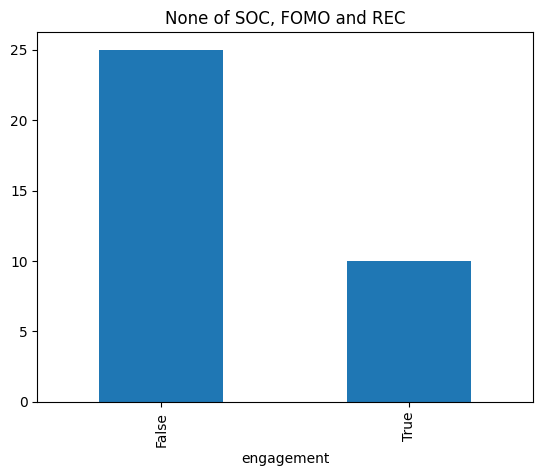

In [36]:
# For PIA
mask = (~df_resp['FOMO']) & (~df_resp['SOC']) & (~df_resp['REC'])
df_aut = df_resp[(df_resp['PIA']) & mask]['engagement']
df_aut.value_counts().plot.bar(title='None of SOC, FOMO and REC')

Out 26 insances where `PIA` lead to no engagement, 25 of those contain none of `SOC`, `FOMO`, `REC`. As those 3 are the driving factors for engagement, so their absence leads to such low engagement rate.


In [43]:
def create_combination(row):
    categories = ['FOMO', 'SOC', 'REC']
    combination = '+'.join([f'^{cat}' if not row[cat] else cat for cat in categories])
    return combination

count['combination'] = count.apply(create_combination, axis=1)
count

,FOMO,SOC,REC,engagement,count,combination
0,False,False,False,False,43,^FOMO+^SOC+^REC
1,False,False,False,True,28,^FOMO+^SOC+^REC
2,True,False,False,False,8,FOMO+^SOC+^REC
3,True,False,False,True,8,FOMO+^SOC+^REC
4,False,True,False,False,7,^FOMO+SOC+^REC
5,False,True,False,True,5,^FOMO+SOC+^REC
6,True,True,False,True,5,FOMO+SOC+^REC
7,False,True,True,True,3,^FOMO+SOC+REC
8,False,False,True,True,2,^FOMO+^SOC+REC
9,True,True,False,False,2,FOMO+SOC+^REC


In [44]:
import plotly.express as px

fig = px.bar(count, x='combination',y='count',color='engagement',barmode='group')
fig.show()

In [59]:
def concat_subject_body(x):
    
    return f'Subject: {x[0]}[SEP] Body:{x[1]}'
df_resp['subject'] = df_resp['subject'].apply(lambda x: demoji.replace(x, repl=""))
df_resp['input'] = df_resp[['subject','body']].apply(lambda x: concat_subject_body(x),axis=1)
df_resp

/var/folders/14/5271m2p52j53fmw7g_84t3740000gn/T/ipykernel_28888/3305086984.py:3: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



,subject,body,meeting_link_clicked,responded,num_tokens,persuation_techniques,FOMO,SOC,REC,AUT,EMO,VAL,PIA,engagement,input
1,Data Superpower Unlock Insights Us,I'm reac our marketing analytics can translate...,0,0,39,"['VAL', 'CTA']",False,False,False,False,False,True,False,False,Subject: Data Superpower Unlock Insights Us[SE...
3,Marketing Success Click Away - Let's Chat Anal...,It's clear that you're serious about your busi...,1,0,87,"['PIA', 'CTA', 'VAL']",False,False,False,False,False,True,True,True,Subject: Marketing Success Click Away - Let's ...
5,Turn Data Decisions - Next Competitive Edge,I saw that my previous email hasn’t been opene...,0,0,85,['VAL'],False,False,False,False,False,True,False,False,Subject: Turn Data Decisions - Next Competitiv...
7,"We’re Confident Data, Here’s","Your success is our business. Just last month,...",1,0,122,"['SOC', 'AUT', 'CTA', 'FOMO', 'REC']",True,True,True,True,False,False,False,True,"Subject: We’re Confident Data, Here’s[SEP] Bod..."
9,Marketing Strategy Deserves Best Analytics,Improve your marketing effectiveness through d...,0,0,58,"['VAL', 'AUT', 'FOMO', 'CTA']",True,False,False,True,False,True,False,False,Subject: Marketing Strategy Deserves Best Anal...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,Re: Unlock Potential Tailored HR Solutions,Noticed that you're swamped? We tailor HR solu...,0,0,31,['PIA'],False,False,False,False,False,False,True,False,Subject: Re: Unlock Potential Tailored HR Solu...
149,Streamline HR Boost Performance,Efficiency is king – especially in HR. We opti...,1,0,56,"['VAL', 'CTA']",False,False,False,False,False,True,False,True,Subject: Streamline HR Boost Performance[SEP] ...
150,Boost Brand Visibility,Want to skyrocket your company's market presen...,0,0,38,"['PIA', 'VAL', 'CTA']",False,False,False,False,False,True,True,False,Subject: Boost Brand Visibility[SEP] Body:Want...
151,Outpace Competitors Insightful Analytics,I noticed you're navigating through the vast u...,0,0,62,"['PIA', 'VAL', 'CTA']",False,False,False,False,False,True,True,False,Subject: Outpace Competitors Insightful Analyt...


In [60]:
from transformers import BertForSequenceClassification, BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model_body = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [61]:
train_df, test_df = train_test_split(df_resp, test_size=0.2, random_state=17,stratify=df_resp['engagement'])
train_dataset = EmailDataset(train_df['input'].values, train_df['engagement'].values, tokenizer,)
test_dataset = EmailDataset(test_df['input'].values, test_df['engagement'].values, tokenizer)

In [62]:
import wandb
import os

%env WANDB_PROJECT=email-analysis

%env WANDB_LOG_MODEL=false

%env WANDB_WATCH=false

env: WANDB_PROJECT=email-analysis
env: WANDB_LOG_MODEL=false
env: WANDB_WATCH=false


In [63]:
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score
# Training settings
training_args = TrainingArguments(
    output_dir='./results_body',
    report_to="wandb",
    num_train_epochs=20,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    warmup_steps=20,
    weight_decay=0.01,
    logging_dir='logs_only_body',
    logging_strategy='epoch',
    save_total_limit=1,
    load_best_model_at_end=True,
    save_strategy='epoch',
    evaluation_strategy='epoch',
)



In [64]:

trainer = Trainer(
    model=model_body,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=lambda p: {"accuracy": accuracy_score(p.predictions.argmax(axis=1), p.label_ids)}
)

# Train the model
trainer.train()

wandb.finish()

python(29701) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


  0%|          | 0/460 [00:00<?, ?it/s]

{'loss': 0.7097, 'learning_rate': 4.965909090909091e-05, 'epoch': 1.0}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 0.6710935831069946, 'eval_accuracy': 0.5217391304347826, 'eval_runtime': 0.6178, 'eval_samples_per_second': 37.226, 'eval_steps_per_second': 4.856, 'epoch': 1.0}
{'loss': 0.6685, 'learning_rate': 4.704545454545455e-05, 'epoch': 2.0}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 0.6280937790870667, 'eval_accuracy': 0.5217391304347826, 'eval_runtime': 0.5833, 'eval_samples_per_second': 39.428, 'eval_steps_per_second': 5.143, 'epoch': 2.0}
{'loss': 0.566, 'learning_rate': 4.443181818181818e-05, 'epoch': 3.0}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 0.696690022945404, 'eval_accuracy': 0.6086956521739131, 'eval_runtime': 0.559, 'eval_samples_per_second': 41.148, 'eval_steps_per_second': 5.367, 'epoch': 3.0}
{'loss': 0.5281, 'learning_rate': 4.181818181818182e-05, 'epoch': 4.0}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 0.6993866562843323, 'eval_accuracy': 0.6521739130434783, 'eval_runtime': 0.5824, 'eval_samples_per_second': 39.494, 'eval_steps_per_second': 5.151, 'epoch': 4.0}
{'loss': 0.2252, 'learning_rate': 3.9204545454545456e-05, 'epoch': 5.0}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 1.5394953489303589, 'eval_accuracy': 0.6521739130434783, 'eval_runtime': 0.5674, 'eval_samples_per_second': 40.534, 'eval_steps_per_second': 5.287, 'epoch': 5.0}
{'loss': 0.2284, 'learning_rate': 3.659090909090909e-05, 'epoch': 6.0}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 2.0758283138275146, 'eval_accuracy': 0.6521739130434783, 'eval_runtime': 0.5761, 'eval_samples_per_second': 39.923, 'eval_steps_per_second': 5.207, 'epoch': 6.0}
{'loss': 0.0728, 'learning_rate': 3.397727272727273e-05, 'epoch': 7.0}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 1.6249237060546875, 'eval_accuracy': 0.782608695652174, 'eval_runtime': 0.5871, 'eval_samples_per_second': 39.177, 'eval_steps_per_second': 5.11, 'epoch': 7.0}
{'loss': 0.1612, 'learning_rate': 3.1363636363636365e-05, 'epoch': 8.0}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 2.357804775238037, 'eval_accuracy': 0.6521739130434783, 'eval_runtime': 0.5732, 'eval_samples_per_second': 40.125, 'eval_steps_per_second': 5.234, 'epoch': 8.0}
{'loss': 0.0025, 'learning_rate': 2.8749999999999997e-05, 'epoch': 9.0}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 2.6169044971466064, 'eval_accuracy': 0.6521739130434783, 'eval_runtime': 0.5554, 'eval_samples_per_second': 41.412, 'eval_steps_per_second': 5.402, 'epoch': 9.0}
{'loss': 0.0004, 'learning_rate': 2.6136363636363637e-05, 'epoch': 10.0}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 2.7538387775421143, 'eval_accuracy': 0.6521739130434783, 'eval_runtime': 0.5969, 'eval_samples_per_second': 38.532, 'eval_steps_per_second': 5.026, 'epoch': 10.0}
{'loss': 0.0003, 'learning_rate': 2.3522727272727273e-05, 'epoch': 11.0}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 2.8254573345184326, 'eval_accuracy': 0.6086956521739131, 'eval_runtime': 0.6569, 'eval_samples_per_second': 35.013, 'eval_steps_per_second': 4.567, 'epoch': 11.0}
{'loss': 0.0003, 'learning_rate': 2.090909090909091e-05, 'epoch': 12.0}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 2.895873785018921, 'eval_accuracy': 0.6086956521739131, 'eval_runtime': 0.5845, 'eval_samples_per_second': 39.352, 'eval_steps_per_second': 5.133, 'epoch': 12.0}
{'loss': 0.0003, 'learning_rate': 1.8295454545454546e-05, 'epoch': 13.0}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 2.937613010406494, 'eval_accuracy': 0.6086956521739131, 'eval_runtime': 0.5605, 'eval_samples_per_second': 41.032, 'eval_steps_per_second': 5.352, 'epoch': 13.0}
{'loss': 0.0002, 'learning_rate': 1.5681818181818182e-05, 'epoch': 14.0}


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 2.9885425567626953, 'eval_accuracy': 0.6086956521739131, 'eval_runtime': 0.5949, 'eval_samples_per_second': 38.664, 'eval_steps_per_second': 5.043, 'epoch': 14.0}


KeyboardInterrupt: 

In [65]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


eval/accuracy,▁▁▃▅▅▅█▅▅▅▃▃▃▃
eval/loss,▁▁▁▁▄▅▄▆▇▇████
eval/runtime,▅▃▁▃▂▂▃▂▁▄█▃▁▄
eval/samples_per_second,▃▆█▆▇▆▆▇█▅▁▆█▅
eval/steps_per_second,▃▆█▆▇▆▆▇█▅▁▆█▅
train/epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
train/global_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
train/learning_rate,█▇▇▆▆▅▅▄▄▃▃▂▂▁
train/loss,██▇▆▃▃▂▃▁▁▁▁▁▁
eval/accuracy,0.6087
eval/loss,2.98854
